In [8]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from collections import defaultdict
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
from pycausal import prior as p
import itertools

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})

def make_categorical(df, complete_df, categoricals):   
    retval = None
    for key in df.columns:
        if retval is not None:
            if key in categoricals:
                retval = np.concatenate((retval, to_categorical(df[key], len(complete_df[key].unique()))), axis = 1)
            else:
                retval = np.concatenate((retval, df[key].values[...,np.newaxis]), axis = 1)
        else:
            if key in categoricals:
                retval = to_categorical(df[key], len(complete_df[key].unique()))
            else:
                retval = np.expand_dims(df[key], axis = 1)
    return retval
num_models = 100
           
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()

inputs = ['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure']
target = ['DiabetesPedigreeFunction']
categoricals = [] 

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('~/Desktop/Kaggle/diabetes.csv')
# Prior knowledge knows that the test prep comes before the outcome.
df.head()

def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))

df['Pregnancies'] = normalize(df['Pregnancies'])
df['Glucose'] = normalize(df['Glucose'])
df['BloodPressure'] = normalize(df['BloodPressure'])
df['SkinThickness'] = normalize(df['SkinThickness'])
df['Insulin'] = normalize(df['Insulin'])
df['BMI'] = normalize(df['BMI'])
df['DiabetesPedigreeFunction'] = normalize(df['DiabetesPedigreeFunction'])
df['Age'] = normalize(df['Age'])
df.drop(columns = ['Outcome', 'SkinThickness', 'Pregnancies'], inplace = True)
df.reset_index(drop=True, inplace = True)
original_df = df.copy()
len(df)

768

[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [51

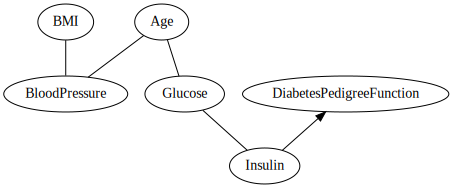

In [10]:
import pydot
from IPython.display import SVG
def examine_graph_continuous(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               )
    return tetrad.getTetradGraph()

def examine_graph_mixed(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 9, 
           structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)

    return tetrad.getTetradGraph()

def examine_graph_discrete(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'bdeu', priorKnowledge = prior, dataType = 'discrete',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)
    return tetrad.getTetradGraph()
    
def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.Dense(dense[0], activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    #x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu', kernel_initializer = 'he_normal')(x)
        #x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'softmax', kernel_initializer = 'he_normal')(x)
    model = keras.Model(inputs, outputs)
    return model

def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 9,
           structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True,
              penalty = 200)
    
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)    


temporal = [inputs, target]

prior = p.knowledge( addtemporal = temporal)
#prior = None

g = examine_graph_continuous(df, prior = prior)
dot_str = pc.tetradGraphToDot(g)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()

known_conx = set({})
for i in tetrad.getEdges():
    if ' --> ' in i:
        known_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
known_conx

prior = p.knowledge(requiredirect =  list(map(list, known_conx)),)
models = []
model_names = []
randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/random' + str(i))
    print(models, model_names)    
else:
    model_layers = [512,256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/pima' + str(i))

print(models, model_names)
SVG(svg_str)



In [11]:
df = original_df.copy()
print(len(df))
holdout = 140
    #df_test = df[df['charges'] > 0.54].copy()
continuous = inputs

small = random.randint(0,1)
cont = random.randint(0, len(continuous) - 1)
if small == 0:
    df_test = df.nsmallest(holdout, continuous[cont])
else:
    df_test = df.nlargest(holdout, continuous[cont])
df.head()
print(len(df), len(df_test))
df.drop(df_test.index, inplace = True)
print(len(df))
df_test.reset_index(inplace = True)
print(len(df))
df.sample(frac= 1).reset_index(inplace = True) # this will shuffle and reset index

x_test = df_test[inputs]
y_test = df_test[target]
causal_split = 0.2
val_split = 0.2
train_split = 1 - (causal_split + val_split)
x_causal = df[inputs][-int(causal_split * len(df)) :]
y_causal = df[target][-int(causal_split * len(df)) :]
x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]
x_train = df[inputs][:int(train_split * len(df))]
y_train = df[target][:int(train_split * len(df))]

768
768 140
628
628


In [12]:
x_causal.head()

,Glucose,Insulin,BMI,Age,BloodPressure
612,0.844221,0.379433,0.569300,0.316667,0.721311
613,0.527638,0.000000,0.484352,0.083333,0.655738
614,0.693467,0.170213,0.538003,0.483333,0.606557
615,0.532663,0.000000,0.384501,0.100000,0.590164
616,0.587940,0.000000,0.427720,0.150000,0.786885


In [13]:
bestMSE = []
bestBIC = []
bestCOMBO = []

for t in range(10):
    # let's split our df into two by race.  Let's see what happens if we 
    df = original_df.copy()

    holdout = 140
        #df_test = df[df['charges'] > 0.54].copy()
    continuous = inputs
    
    small = random.randint(0,1)
    cont = random.randint(0, len(continuous) - 1)
    if small == 0:
        df_test = df.nsmallest(holdout, continuous[cont])
    else:
        df_test = df.nlargest(holdout, continuous[cont])
    print(t, continuous[cont])
    df.drop(df_test.index, inplace = True)
    df_test.reset_index(inplace = True)
    df.sample(frac= 1).reset_index(inplace = True) # this will shuffle and reset index

    x_test = df_test[inputs]
    y_test = df_test[target]
    causal_split = 0.2
    val_split = 0.2
    train_split = 1 - (causal_split + val_split)
    x_causal = df[inputs][-int(causal_split * len(df)) :]
    y_causal = df[target][-int(causal_split * len(df)) :]
    x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
    y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]
    x_train = df[inputs][:int(train_split * len(df))]
    y_train = df[target][:int(train_split * len(df))]
    #x_test_NN = make_categorical(x_test, original_df, categoricals)
    #x_causal_NN = make_categorical(x_causal, original_df, categoricals)
    #x_val_NN = make_categorical(x_val, original_df, categoricals)
    #x_train_NN = make_categorical(x_train, original_df, categoricals)
    verbosity = 0
    for idx, model_name in enumerate(model_names):
        #print(model_name)

        if type(models[idx]) is list:
            #clear session
            keras.backend.clear_session() 
            #get model according to specification
            model = get_model(models[idx], [0.2] * len(models), np.shape(x_train)[1])
            callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                         EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
            model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
            #print(len(X), len(y))
            model.fit(x_train, y_train, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
        else:
            models[idx].fit(X,y)




    violation = []
    generalization = []
    metrics = []
    proposed = []
    x_causal.reset_index(drop = True, inplace = True)

    for idx, model_name in enumerate(model_names):
        #print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(x_test)
        generalization.append(mean_absolute_error(y_test,y_pred))

        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal)
        metrics.append(mean_absolute_error(y_causal, y_causal_pred))
        #print("AUC = ", roc_auc_score(y_causal, y_causal_pred))
        y_causal_pred[y_causal_pred > 0.5] = 1
        y_causal_pred[y_causal_pred <= 0.5] = 0
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)
        #print(len(causal_df))



        #print(x_causal.head)
        bic_pred = get_bic(causal_df, prior)
        #print(bic_pred, tetrad.getEdges())
        #print(bic_pred)
        found_conx = set({})
        for i in tetrad.getEdges():
            if ' --> ' in i:
                found_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
        found_conx

        if found_conx == known_conx:
            proposed.append(bic_pred)
            violation.append(0)
        else:
            print("******Found an error")
            # for now just remove bad model.  Will need to add it to distance metric.
            proposed.append(bic_pred)
            violation.append(1)
            #metrics = metrics[:-1]
            #generalization = generalization[:-1]
    total = normalize(metrics) + normalize(proposed)
    nbest = 10
    final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
    print("MSE = ", np.mean(final.nsmallest(nbest, 'metrics')['generalization']))
    print("BIC = ", np.mean(final.nsmallest(nbest, 'proposed')['generalization']))
    print("COMB = ",np.mean(final.nsmallest(nbest, 'combined')['generalization']))
    bestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'])
    bestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'])
    bestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'])
    

np.mean(bestMSE), np.mean(bestBIC), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

0 BloodPressure
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an err

/home/tkyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found a

******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
MSE =  0.7811546907405148
BIC =  0.7811546907405148
COMB =  nan
5 Glucose
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
******Found an error
**

KeyboardInterrupt: 

In [7]:
x_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.166667
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.200000
6,0.176471,0.391960,0.409836,0.323232,0.104019,0.461997,0.083333
8,0.117647,0.989950,0.573770,0.454545,0.641844,0.454545,0.533333
13,0.058824,0.949749,0.491803,0.232323,1.000000,0.448584,0.633333
14,0.294118,0.834171,0.590164,0.191919,0.206856,0.384501,0.500000
16,0.000000,0.592965,0.688525,0.474747,0.271868,0.682563,0.166667
18,0.058824,0.517588,0.245902,0.383838,0.098109,0.645306,0.200000


In [8]:
y_test_NN

NameError: name 'y_test_NN' is not defined

In [ ]:
original_df = df.copy()
df = original_df.copy()

len(df[df['BMI'] > 0.6])

In [ ]:
x_test

In [ ]:
fig, ax = plt.subplots()
b,m = polyfit(proposed,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(proposed,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(proposed,generalization, '.')
plt.plot(proposed, b + m * np.array(proposed), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(metrics,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(metrics,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(metrics,generalization, '.')
plt.plot(metrics, b + m * np.array(metrics), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


total = normalize(metrics) - (normalize(proposed) + np.array(violation))
fig, ax = plt.subplots()
b,m = polyfit(total,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(total,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(total,generalization, '.')
plt.plot(total, b + m * np.array(total), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


In [ ]:
nbest = 5
final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
print("MSE = ", np.mean(final.nlargest(nbest, 'metrics')['generalization']))
print("BIC = ", np.mean(final.nlargest(nbest, 'proposed')['generalization']))
print("COMB = ",np.mean(final.nlargest(nbest, 'combined')['generalization']))

In [ ]:
model = load_model('temp/pima50')
roc_auc_score(y_val, model.predict(x_train_NN)[:,1])